In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
from scipy.stats import mstats  # 単回帰.ipynbでは、未使用
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/real_estate1.xlsx")

信頼区間：精度  
予測区間：モデルにより取りうる範囲  
generated quantities

In [4]:
stan_model = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_s;
  real X_s[N_s];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N){
    Y[n] ~ normal(a * X[n] + b, sigma);
  }
}

generated quantities {
  real Y_s[N_s];
  for (n in 1:N_s){
    Y_s[n] = normal_rng(a * X_s[n] + b, sigma);
  }
}

"""

In [5]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_81acff9de421dcd46dd949b5b0a70352 NOW.


In [6]:
X_s = np.arange(40,90,1)  # 予測区間
N_s = X_s.shape[0]
stan_data = {"N":df.shape[0],"X":df["space"],"Y":df["value"],"N_s":N_s,"X_s":X_s}

In [7]:
fit = sm.sampling(data = stan_data, iter = 2000, warmup= 500, chains= 3, seed=123)

In [9]:
fit.extract("a")  # MCMCでサンプリング取得した"a"の値をarrayで取得

OrderedDict([('a',
              array([ 76.41266253,  93.94065493,  80.63040866, ...,  95.98200868,
                      53.71508784, 105.92215028]))])

In [15]:
fit.extract()

OrderedDict([('a',
              array([ 76.41266253,  93.94065493,  80.63040866, ...,  95.98200868,
                      53.71508784, 105.92215028])),
             ('b',
              array([ -561.55496799, -1909.86642069, -1074.95954857, ...,
                     -1709.27413073,   967.83287616, -2906.2669466 ])),
             ('sigma',
              array([619.90458227, 617.69534307, 464.08057631, ..., 606.19650203,
                     864.23714251, 653.98174108])),
             ('Y_s',
              array([[2294.27605834, 3514.28858887, 2488.67046828, ..., 6417.71304102,
                      5567.66601253, 5241.66336519],
                     [2041.32586214, 2063.52099482, 2431.06705493, ..., 7223.87892607,
                      5739.2849962 , 6356.12569545],
                     [2051.87128719, 1638.31423125, 2882.93646296, ..., 6029.77266042,
                      6102.38628348, 5869.81921034],
                     ...,
                     [1435.28210063, 1497.00088542, 2568.1

In [16]:
ms_a = fit.extract("a")["a"]  # サンプルを受け取る

In [17]:
ms_a

array([ 76.41266253,  93.94065493,  80.63040866, ...,  95.98200868,
        53.71508784, 105.92215028])

(array([  17.,   70.,  290.,  793., 1342., 1250.,  538.,  169.,   27.,
           4.]),
 array([ 33.90050792,  43.03118731,  52.1618667 ,  61.29254608,
         70.42322547,  79.55390486,  88.68458425,  97.81526363,
        106.94594302, 116.07662241, 125.20730179]),
 <a list of 10 Patch objects>)

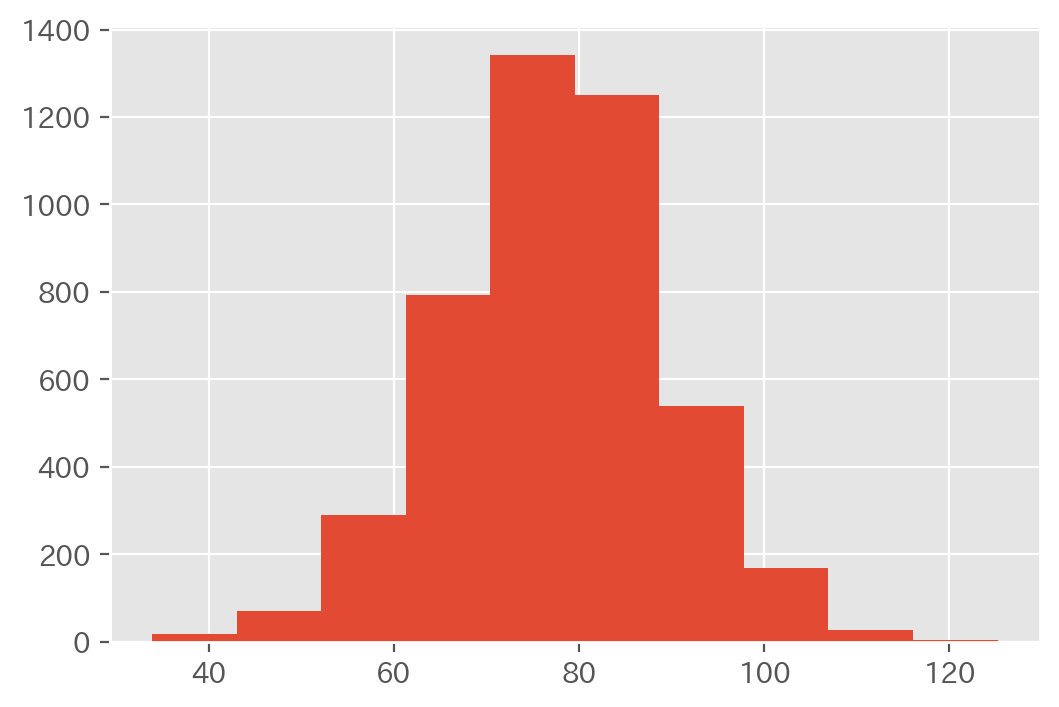

In [18]:
plt.hist(ms_a)  # 事後分布（の再現）

In [19]:
ms_b = fit.extract("b")["b"]

In [20]:
df_b = pd.DataFrame([])  # 4,500のサンプル（信頼区間）格納
for i in range(40, 90, 1):
    df_b[i] = ms_a * i + ms_b

In [21]:
df_b

,40,41,42,43,44,45,46,47,48,49,...,80,81,82,83,84,85,86,87,88,89
0,2494.951533,2571.364196,2647.776858,2724.189521,2800.602183,2877.014846,2953.427508,3029.840171,3106.252833,3182.665496,...,5551.458034,5627.870697,5704.283359,5780.696022,5857.108684,5933.521347,6009.934009,6086.346672,6162.759335,6239.171997
1,1847.759777,1941.700432,2035.641086,2129.581741,2223.522396,2317.463051,2411.403706,2505.344361,2599.285016,2693.225671,...,5605.385974,5699.326629,5793.267284,5887.207939,5981.148594,6075.089249,6169.029904,6262.970558,6356.911213,6450.851868
2,2150.256798,2230.887207,2311.517615,2392.148024,2472.778432,2553.408841,2634.039250,2714.669658,2795.300067,2875.930476,...,5375.473144,5456.103553,5536.733962,5617.364370,5697.994779,5778.625188,5859.255596,5939.886005,6020.516414,6101.146822
3,2362.582375,2437.868728,2513.155081,2588.441433,2663.727786,2739.014139,2814.300491,2889.586844,2964.873197,3040.159549,...,5374.036482,5449.322835,5524.609187,5599.895540,5675.181893,5750.468245,5825.754598,5901.040951,5976.327303,6051.613656
4,2502.128603,2573.937127,2645.745652,2717.554177,2789.362701,2861.171226,2932.979750,3004.788275,3076.596800,3148.405324,...,5374.469586,5446.278110,5518.086635,5589.895160,5661.703684,5733.512209,5805.320733,5877.129258,5948.937782,6020.746307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,2683.472453,2751.343904,2819.215354,2887.086805,2954.958256,3022.829707,3090.701157,3158.572608,3226.444059,3294.315510,...,5398.330483,5466.201934,5534.073385,5601.944835,5669.816286,5737.687737,5805.559188,5873.430638,5941.302089,6009.173540
4496,2540.431482,2618.357792,2696.284102,2774.210413,2852.136723,2930.063033,3007.989343,3085.915653,3163.841964,3241.768274,...,5657.483891,5735.410201,5813.336511,5891.262821,5969.189131,6047.115442,6125.041752,6202.968062,6280.894372,6358.820683
4497,2130.006216,2225.988225,2321.970234,2417.952242,2513.934251,2609.916260,2705.898268,2801.880277,2897.862286,2993.844294,...,5969.286563,6065.268572,6161.250581,6257.232589,6353.214598,6449.196607,6545.178615,6641.160624,6737.142633,6833.124641
4498,3116.436390,3170.151478,3223.866565,3277.581653,3331.296741,3385.011829,3438.726917,3492.442005,3546.157092,3599.872180,...,5265.039903,5318.754991,5372.470079,5426.185167,5479.900255,5533.615342,5587.330430,5641.045518,5694.760606,5748.475694


下限値と上限値をもとめる　$mstats.mquantiles$  
　50%信頼区間→0.25-0.75  
　95%信頼区間→0.025-0.975

In [22]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25,0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025,0.975], axis=0)

In [33]:
fit["a"].mean()

77.66081130373502

In [34]:
fit["b"].mean()

-670.7090759994916

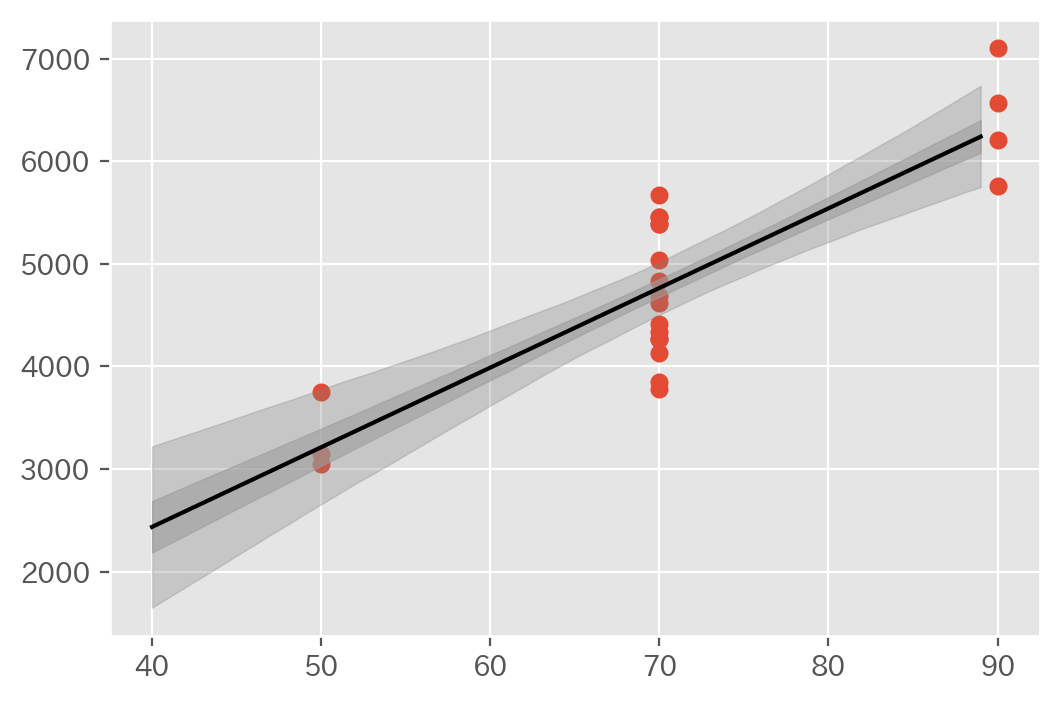

In [32]:
plt.scatter(df["space"],df["value"])

plt.fill_between(X_s, low_y50, high_y50, alpha=0.6, color="darkgray")  # alpha:透明度
plt.fill_between(X_s, low_y95, high_y95, alpha=0.3, color="gray")

a = 77.66
b = -670.7
y = a * X_s + b
plt.plot(X_s, y, color ="black");

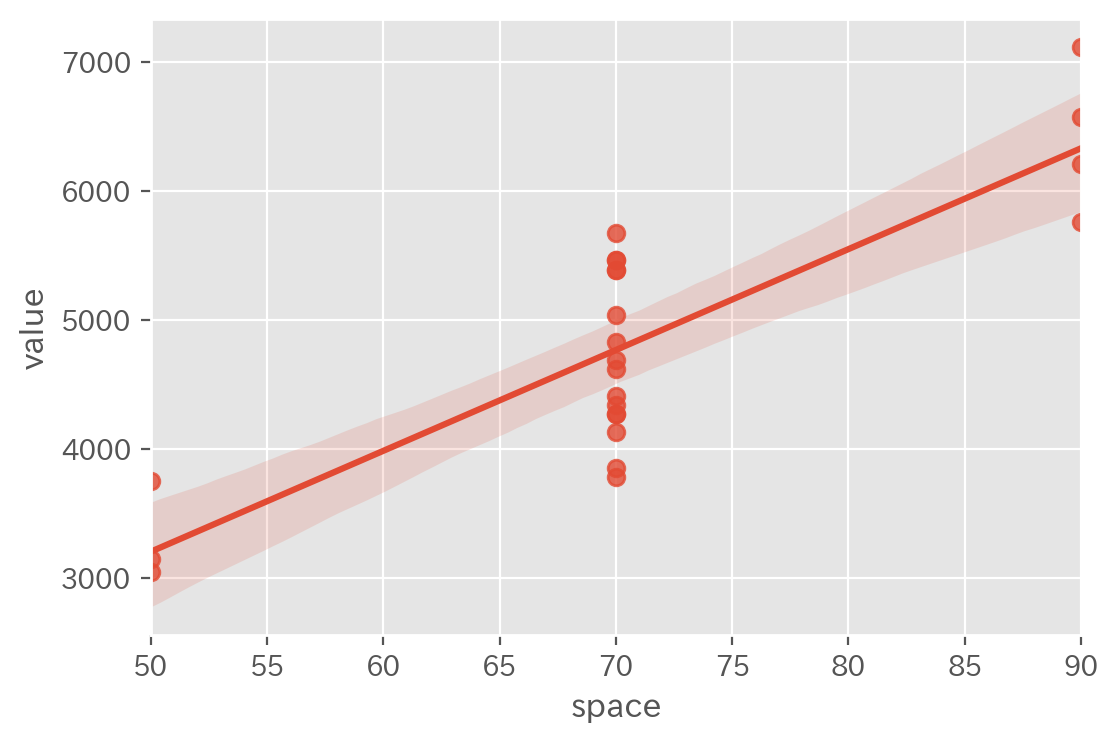

In [40]:
import seaborn as sns
sns.regplot(df["space"],df["value"]);

## 予測区間

In [35]:
Y_p = fit.extract("Y_s")["Y_s"]  # generated quantities で予測した値

In [36]:
low_y, high_y = mstats.mquantiles(Y_p, [0.025,0.975], axis=0)  # バラつく可能性のある区間（95%信頼区間として）

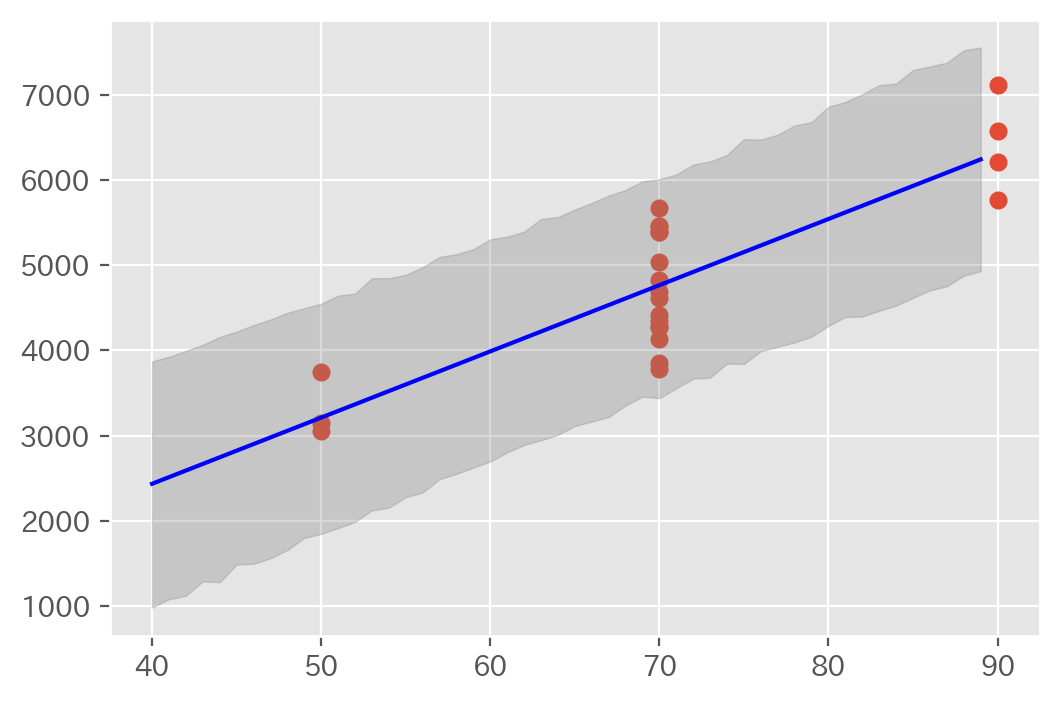

In [38]:
plt.scatter(df["space"],df["value"])
plt.fill_between(X_s, low_y, high_y, alpha=0.3, color="gray")

a = 77.66
b = -670.7
y = a * X_s + b
plt.plot(X_s, y, color ="blue");